# Imports

In [1]:
!pip install sweetviz
!pip install lazypredict

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.1/15.1 MB 47.6 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import warnings
warnings.filterwarnings('ignore')

In [5]:
# load the dataset
df_cust = pd.read_csv('https://raw.githubusercontent.com/sayeedsaqlain/Mall-Customer-Segmentation---Kaggle/master/Mall_Customers.csv')

In [6]:
# check df
df_cust.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


                                             |          | [  0%]   00:00 -> (? left)


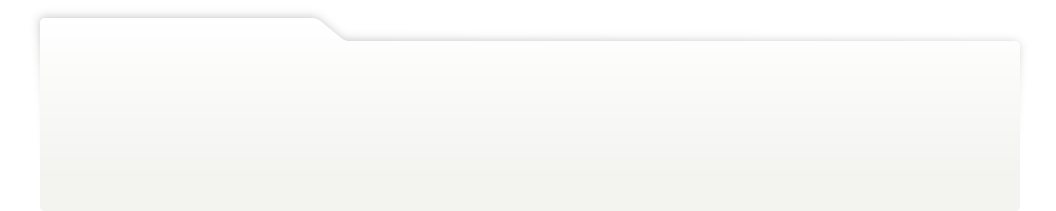
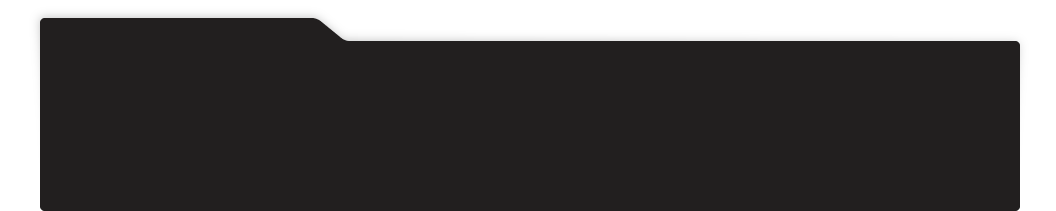
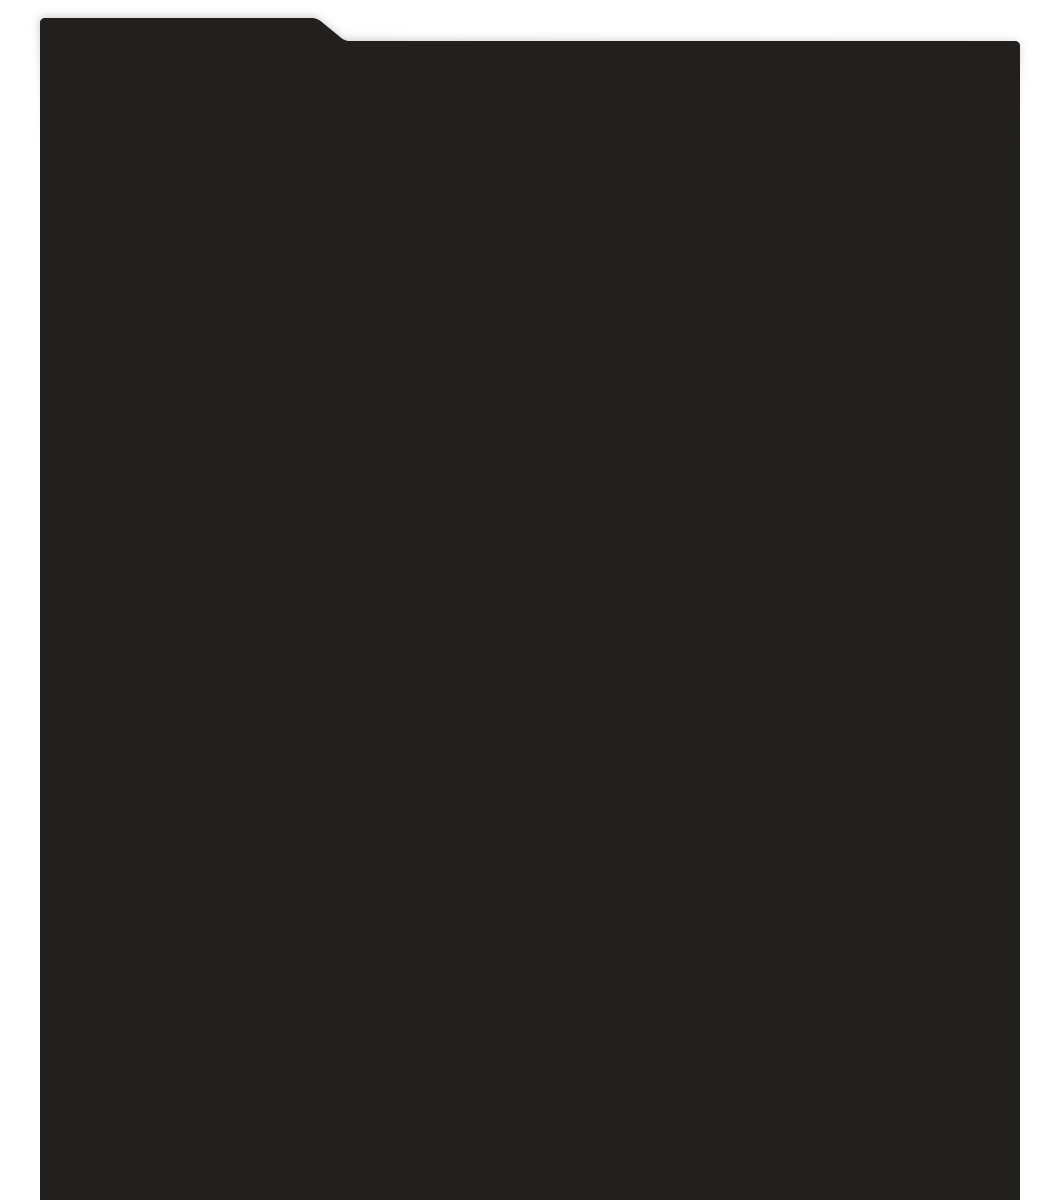
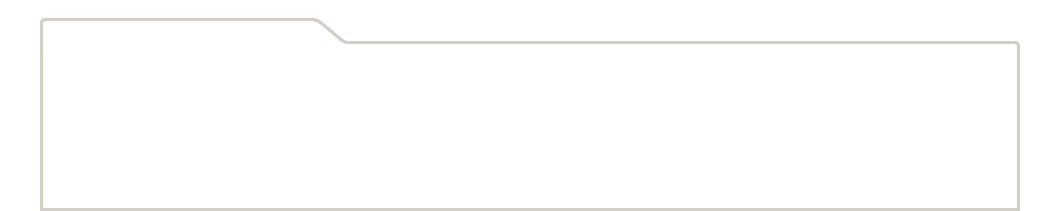
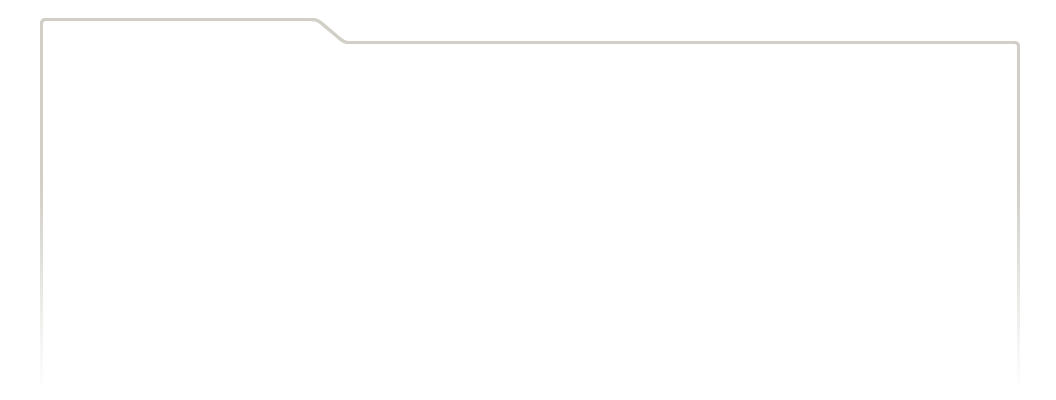
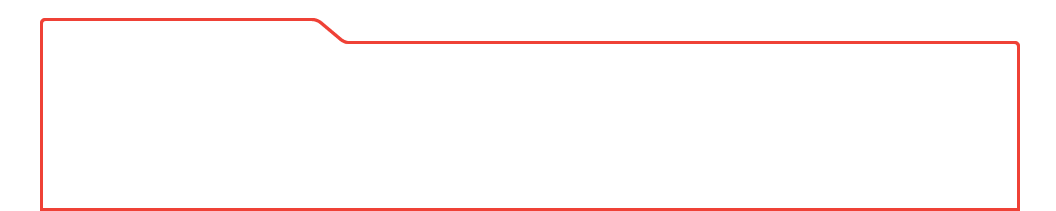
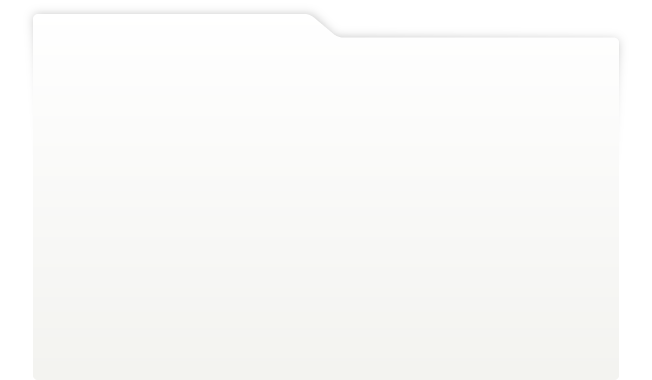
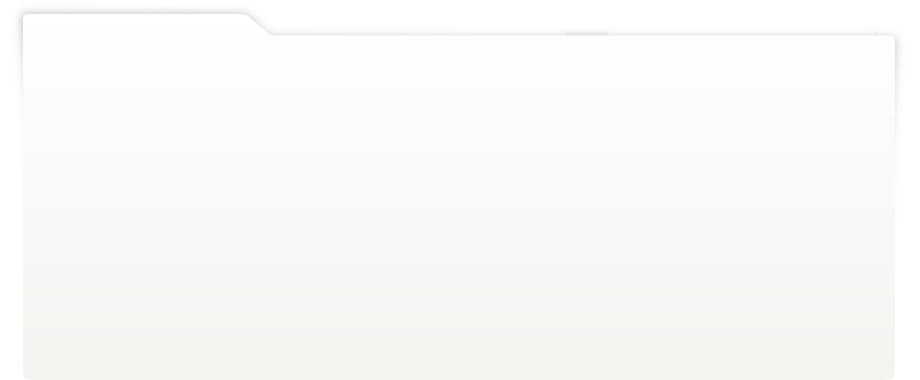
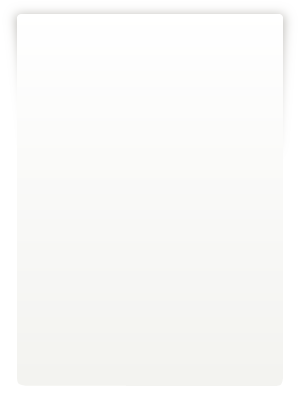
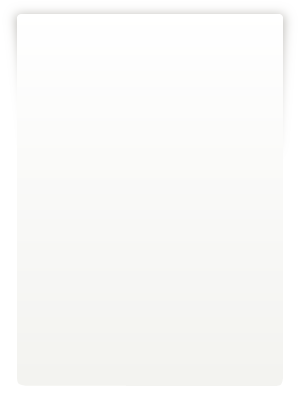
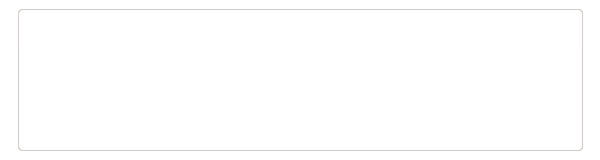
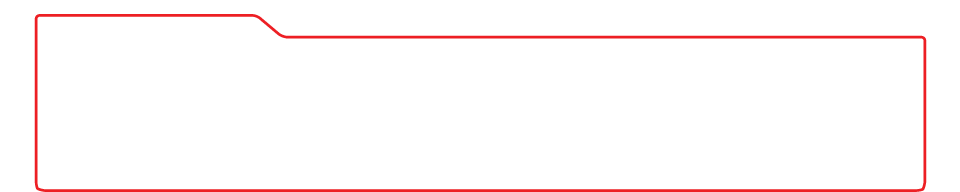
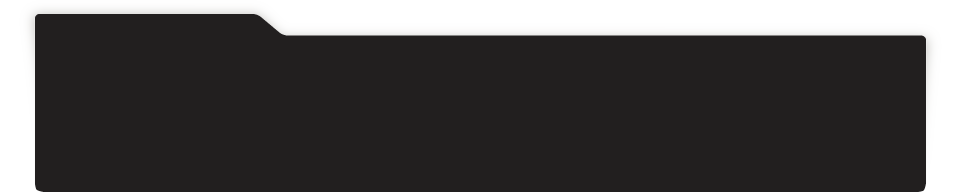
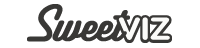
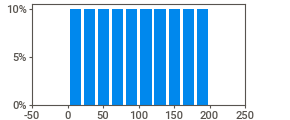
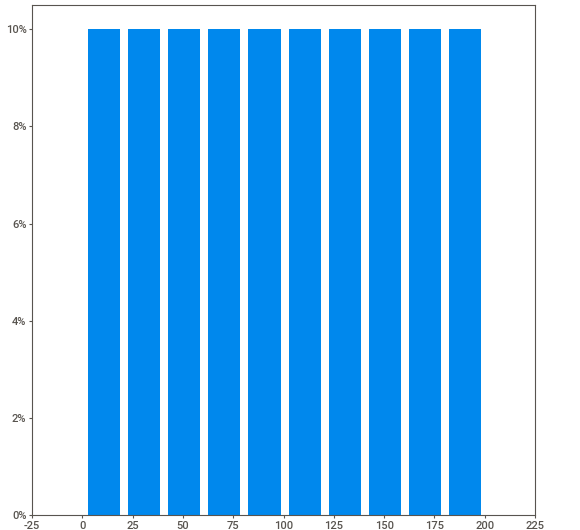
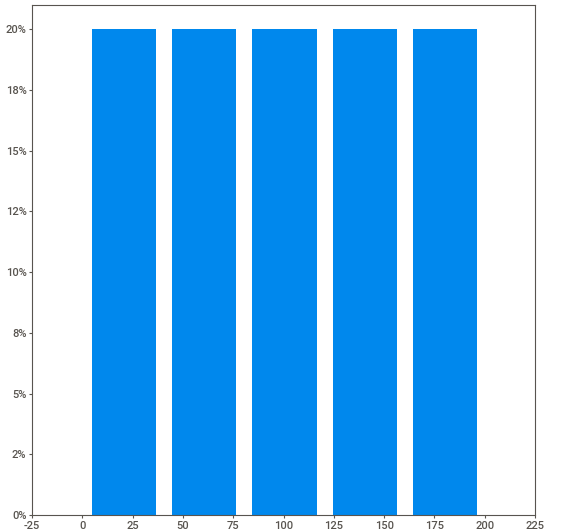
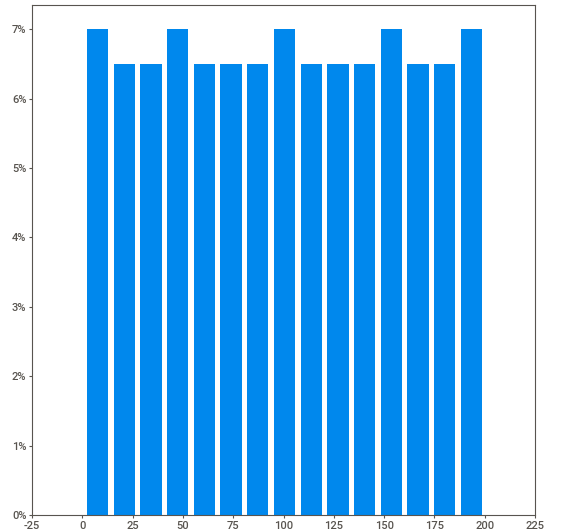
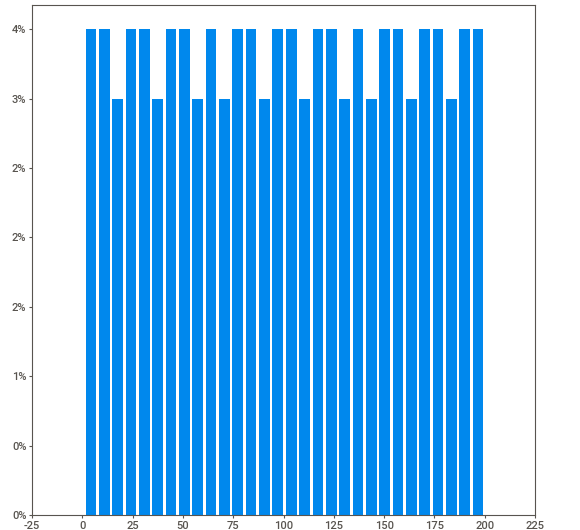
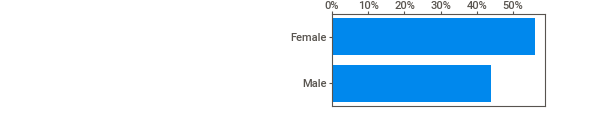
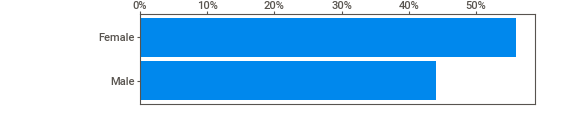
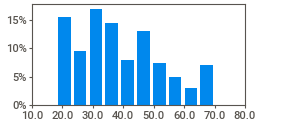
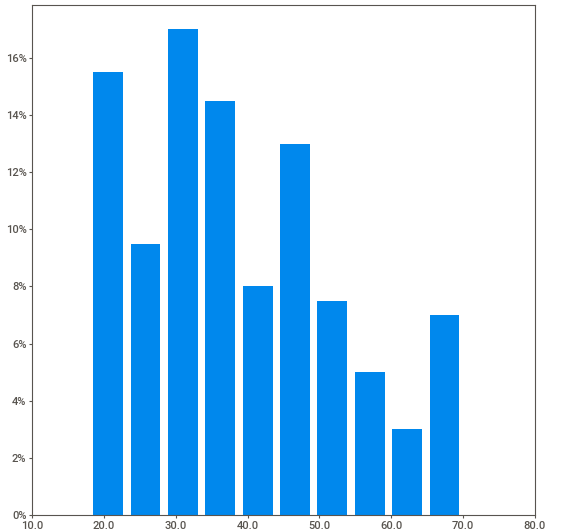
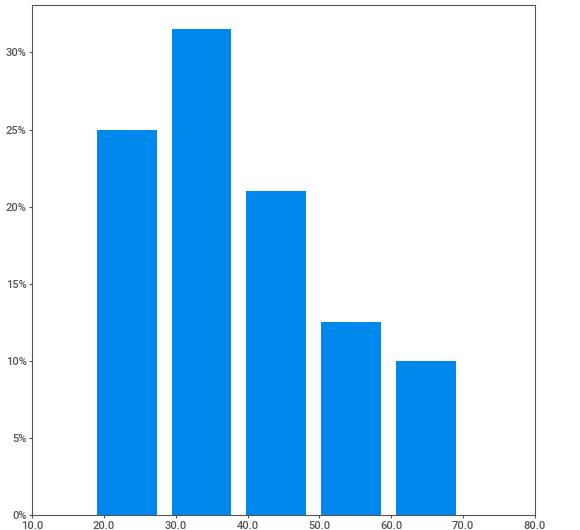
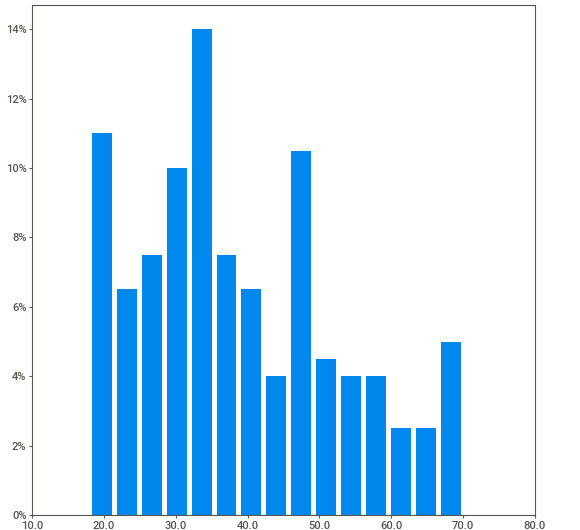
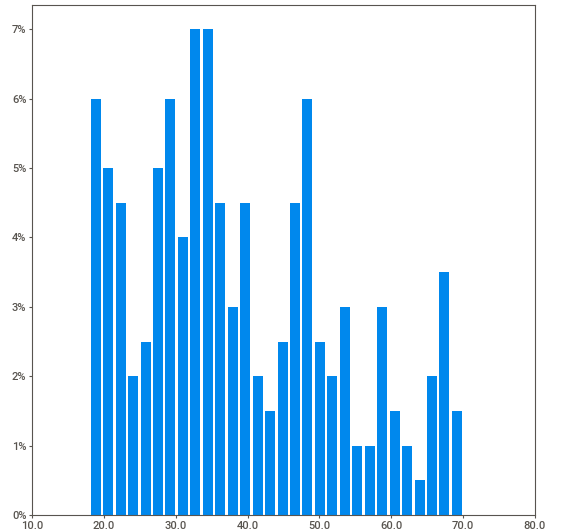
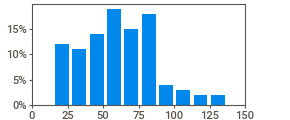
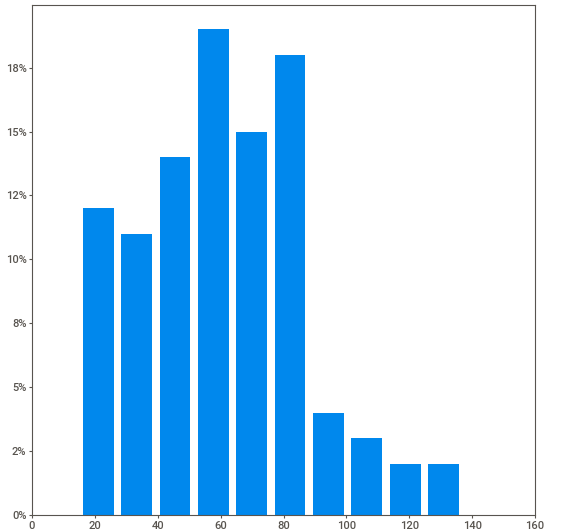
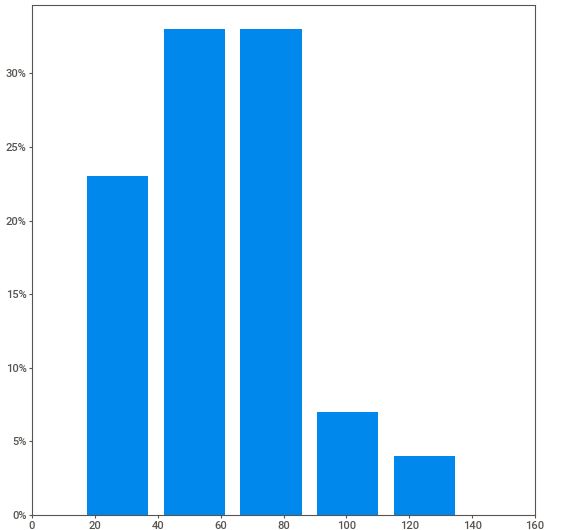
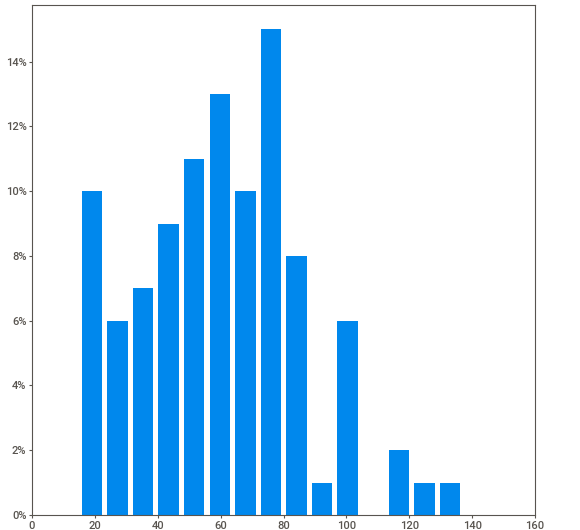
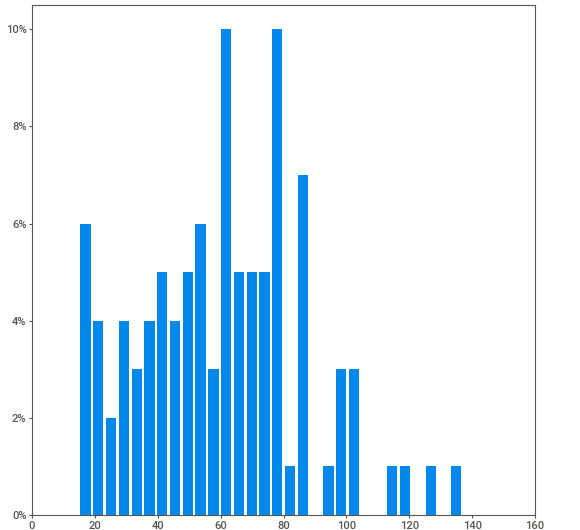
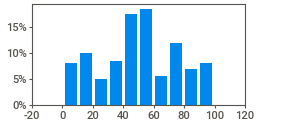
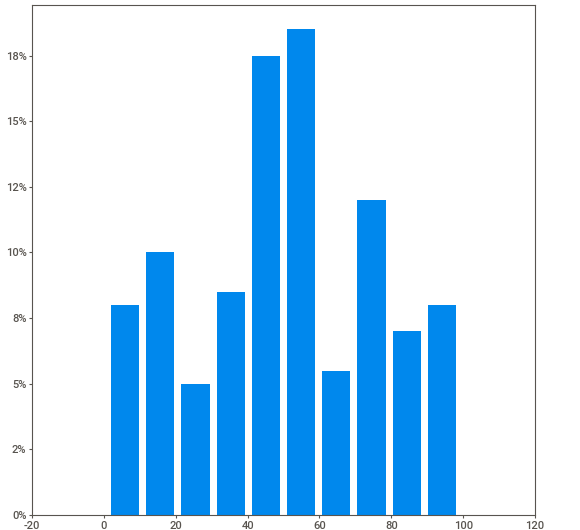
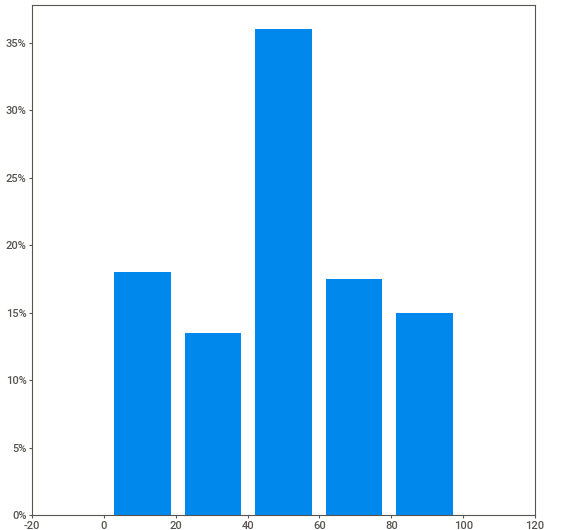
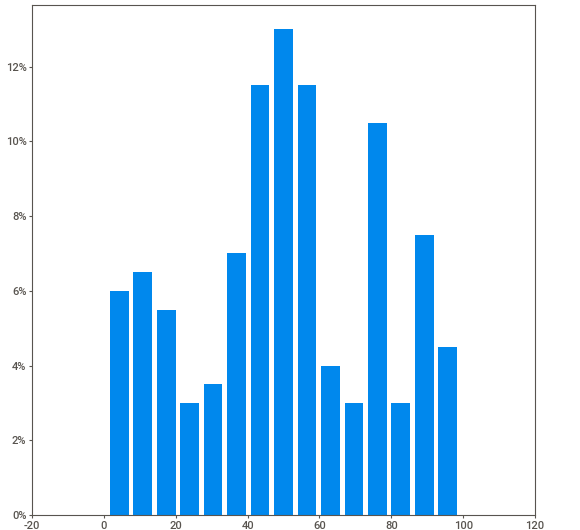
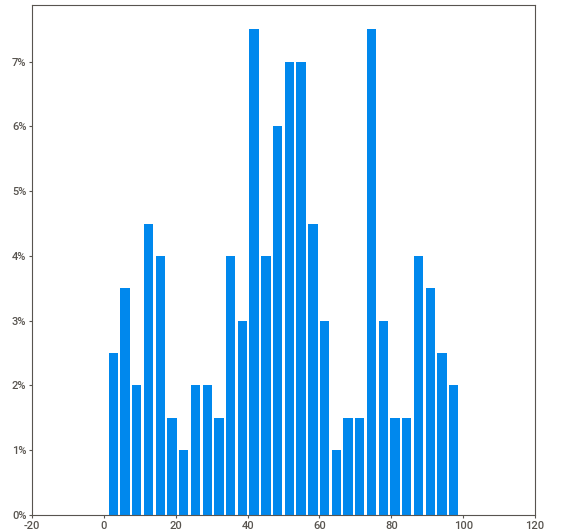
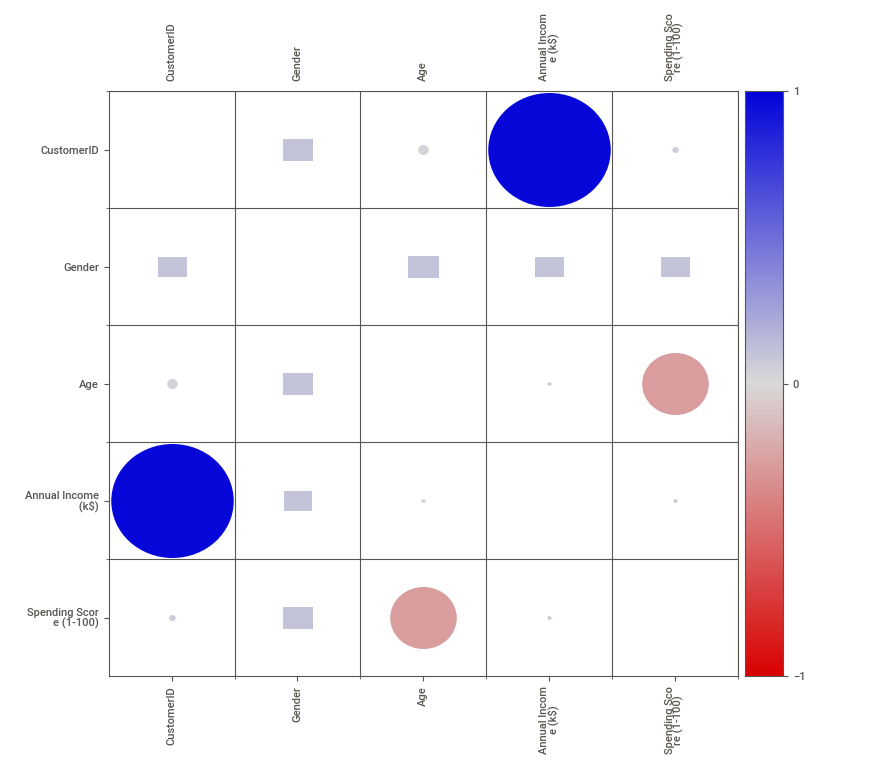
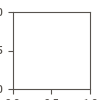

In [7]:
import sweetviz as sv

Report = sv.analyze(df_cust)

Report.show_notebook()

In [8]:
# drop annual income and preprocess annual income (k$)

df_cust["Annual Income"] = df_cust["Annual Income (k$)"] * 1000
df_cust.drop("Annual Income (k$)", axis=1, inplace=True)

In [11]:
# drop customer id
df_cust.drop(columns=["CustomerID"], inplace=True)

In [15]:
# check info
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Spending Score (1-100)  200 non-null    int64 
 3   Annual Income           200 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 6.4+ KB


# Task 1: Cluster by income and score

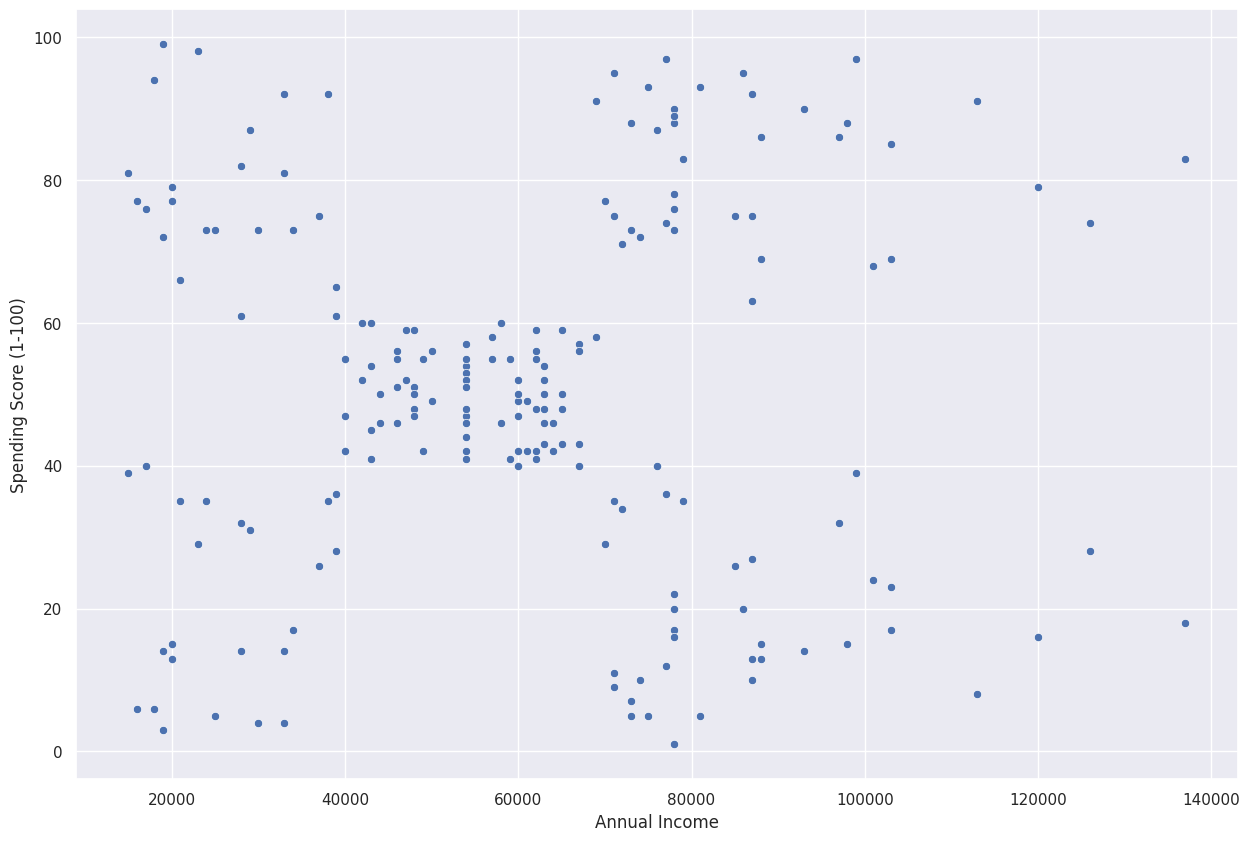

In [16]:
# glance - check visually
sns.set(rc={'figure.figsize': (15, 10)})
sns.scatterplot(data=df_cust, x='Annual Income', y='Spending Score (1-100)');


Hm, if I had to guess I would believe that there are 5 clusters in the data set. So let's try to run a k-mean algorithm with k=5.

In [17]:
# run clustering
from sklearn.cluster import KMeans

df = df_cust[['Annual Income', 'Spending Score (1-100)']]

kmeans = KMeans(n_clusters=5)

pred_kmeans = kmeans.fit_predict(df)

pred_kmeans

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2], dtype=int32)

In [18]:
print(set(pred_kmeans))

{0, 1, 2, 3, 4}


In [19]:
# kmeans cluster centres

kmeans.cluster_centers_

array([[7.88928571e+04, 4.96428571e+01],
       [4.22380952e+04, 5.06666667e+01],
       [1.09700000e+05, 5.20000000e+01],
       [6.04400000e+04, 5.00600000e+01],
       [2.20000000e+04, 4.96562500e+01]])

In [20]:
# fix the scaling
import sklearn.preprocessing as pp

scaler = pp.MinMaxScaler()

X = scaler.fit_transform(df)

In [21]:
np.max(X, axis=0)

array([1., 1.])

In [22]:
# redo the pred_kmeans

kmeans = KMeans(n_clusters=5)

pred_kmeans = kmeans.fit_predict(X)


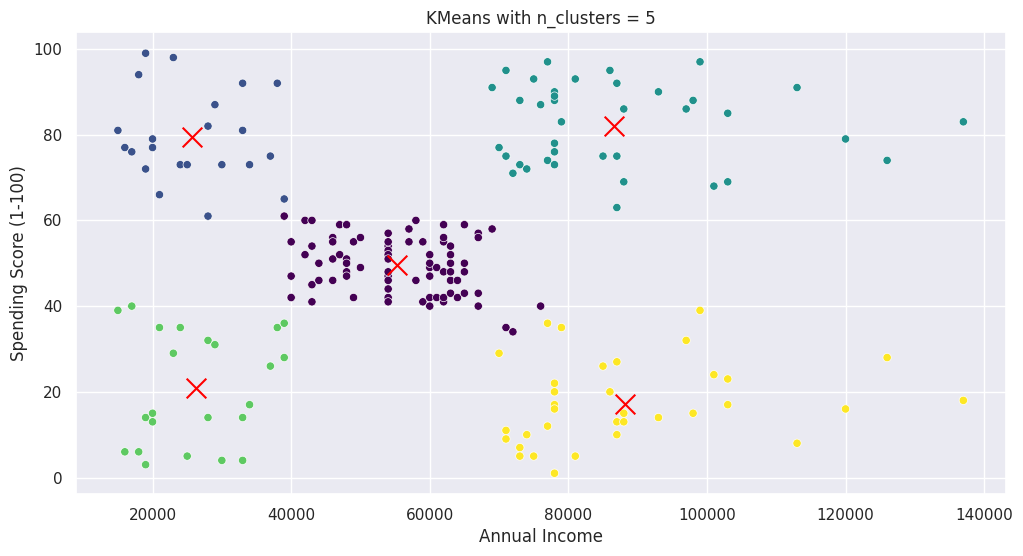

In [25]:
# inverse transform
centers_rw = scaler.inverse_transform(kmeans.cluster_centers_)

# Set the size of the figure
plt.figure(figsize=(12, 6))

# Plotting the clusters
sns.scatterplot(x='Annual Income', y='Spending Score (1-100)', data=df,
                hue=pred_kmeans, palette='viridis', legend=None)

# Plotting the cluster centers
plt.scatter(centers_rw[:,0], centers_rw[:,1], color="red", s=200, marker="x")

plt.title("KMeans with n_clusters = 5");

### Describing Cluster Patterns

It is often a data scientists tasks to also come up with some description of the clusters that the marketing team can then further improve on. So let's quickly do this:

Cluster 1 (bottom left): Low income and low spending

Cluster 2 (top left): Low income but relatively high spending

Cluster 3 (middle): Medium income and medium spending

Cluster 4 (bottom right): High income but low spending

Cluster 5 (top right): High income and high spending

## Making a more educated decision

**What does KMeans actually optimize?**

It optimizes *intertia* of clusters, or *within-cluster sum-of-squares* (WCSS) criterion.

$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$

In words: for each point $x_i$, sum the distance to it's closest centroid $\mu_j$

Choosing k: look for the *sweet spot* of "not-too-many-clusters" for "low-enough-WCSS"

Check out the [user guide](https://scikit-learn.org/stable/modules/clustering.html#k-means).

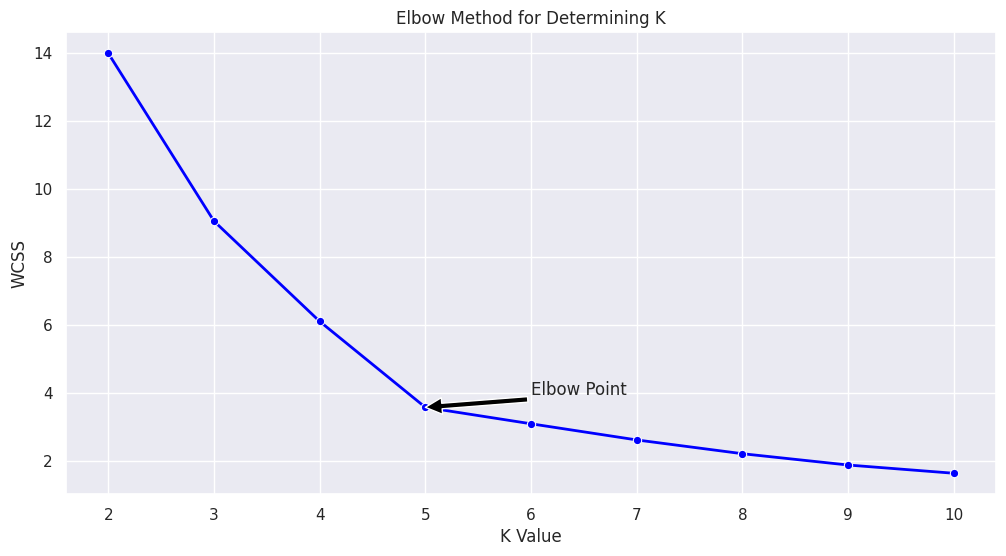

In [29]:
# Elbow Method

inertia_scores = []

for k in range(2, 11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  inertia_scores.append(kmeans.inertia_)

# Creating a DataFrame for Seaborn plotting
df_inertia = pd.DataFrame({'K Value': range(2, 11), 'WCSS': inertia_scores})

# Creating the figure and axis object
fig, ax = plt.subplots(figsize=(12, 6))

# Plotting with Seaborn, assigning the Axes object to ax
sns.lineplot(data=df_inertia, x='K Value', y='WCSS', linewidth=2, color='blue', marker="o", ax=ax)

# Annotating the "elbow" point
x_val = 5
y_val = df_inertia.loc[df_inertia['K Value'] == x_val, 'WCSS'].values[0]
ax.annotate("Elbow Point", xy=(x_val, y_val), xytext=(6, y_val + 0.1*y_val), arrowprops=dict(facecolor='black'))

# Using ax.set() to set titles, labels, and ticks
ax.set(
    title="Elbow Method for Determining K",
    xlabel="K Value",
    ylabel="WCSS",
    xticks=np.arange(2, 11, 1));

In [ ]:
# kneed to find optimal K value
!pip install kneed

In [ ]:
from kneed import KneeLocator
kl = KneeLocator(range(2,11), inertia_scores, curve='convex', direction='decreasing')

kl.elbow

5

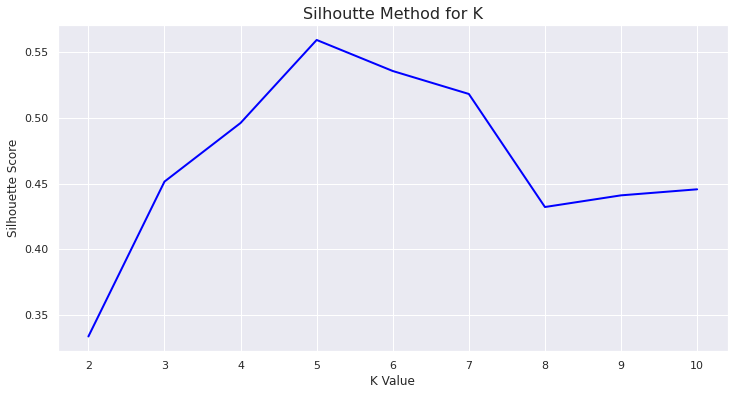

In [ ]:
# metric for evaluation
from sklearn.metrics import silhouette_score

silhouette_scores = []

for k in range(2,11):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(X)
  silhouette_scores.append(silhouette_score(X, kmeans.predict(X)))

plt.figure(figsize=(12, 6))
plt.plot(range(2,11), silhouette_scores, linewidth=2, color='blue')
plt.xlabel("K Value")
plt.xticks(np.arange(2,11,1))
plt.ylabel("Silhouette Score")
plt.title("Silhoutte Method for K", fontsize=16)
plt.show()

In [ ]:
#
df_cust.head()

,Gender,Age,Spending Score (1-100),Annual Income
0,Male,19,39,15000
1,Male,21,81,15000
2,Female,20,6,16000
3,Female,23,77,16000
4,Female,31,40,17000


# Task 2: Cluster by all variables

Business is happy with your first results. However, they would like to integrate Gender and Age as well. They believe that all 4 variables are equally important. Also, they tell you that the number of clusters should stay the same, i.e. continue to be 5.

In [ ]:
# convert gender to binary
df_cust['Male'] = 1*(df_cust['Gender'] == 'Male')

In [ ]:
# define df

df = df_cust[['Age', 'Spending Score (1-100)', 'Annual Income', 'Male']].copy()

In [ ]:
# scale input and run k-means
X = scaler.fit_transform(df)

kmeans = KMeans(n_clusters=5)
pred_kmeans = kmeans.fit_predict(X)

df['cluster'] = pred_kmeans

df.groupby('cluster').mean()

,Age,Spending Score (1-100),Annual Income,Male
cluster,,,,
0,28.438596,67.684211,59666.666667,0.0
1,34.562500,12.000000,81812.500000,1.0
2,58.166667,37.566667,53633.333333,1.0
3,48.109091,34.781818,58818.181818,0.0
4,28.690476,70.238095,60904.761905,1.0


In [ ]:
# compare these cluster patterns

px.scatter_3d(df[df['cluster'].isin([0,2])], x='Age', y='Annual Income', z='Spending Score (1-100)', color='cluster')

Ok, notice that the algorithm seems to have separated completely by man and woman. Let's try to better understand how it separated the two female clusters...

Ok, cluster 0 seems to consists mainly of younger women that have a realtively high spending while cluster 3 consists more of mid-age women spending a little bit less.

In [ ]:
df.groupby('cluster').min()

,Age,Spending Score (1-100),Annual Income,Male
cluster,,,,
0,18,29,16000,0
1,19,1,20000,1
2,47,3,19000,1
3,20,5,16000,0
4,18,35,15000,1


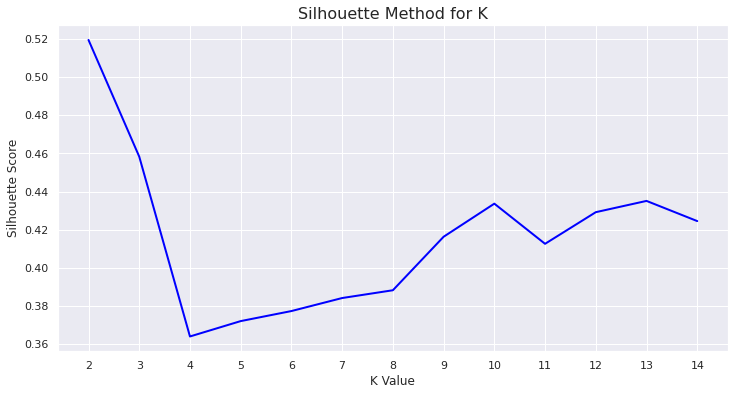

In [ ]:
silhouette_scores = []
for k in range(2,15):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    silhouette_scores.append(silhouette_score(X, kmeans.predict(X)))
plt.figure(figsize=(12,6))
plt.plot(range(2,15), silhouette_scores, linewidth=2, color="blue")
plt.xlabel("K Value")
plt.xticks(np.arange(2,15,1))
plt.ylabel("Silhouette Score")
plt.title('Silhouette Method for K', fontsize=16)
plt.show()

https://stats.stackexchange.com/questions/130974/how-to-use-both-binary-and-continuous-variables-together-in-clustering

Uff, using 5 clusters does not seem ideal! Might have made sense to only use 2 clusters (if ok with the business)...

Let's now go ahead and see how "similar" the clusters are

In [ ]:
df_cust['Cluster_2'] = pred_kmeans

df_cust.head()

,Gender,Age,Spending Score (1-100),Annual Income,Male,Cluster_2
0,Male,19,39,15000,1,4
1,Male,21,81,15000,1,4
2,Female,20,6,16000,0,3
3,Female,23,77,16000,0,0
4,Female,31,40,17000,0,0


In [ ]:
df_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Gender                  200 non-null    object
 1   Age                     200 non-null    int64 
 2   Spending Score (1-100)  200 non-null    int64 
 3   Annual Income           200 non-null    int64 
 4   Male                    200 non-null    int64 
 5   Cluster_2               200 non-null    int32 
dtypes: int32(1), int64(4), object(1)
memory usage: 8.7+ KB


In [ ]:
kmeans = KMeans(n_clusters=5)
pred_kmeans = kmeans.fit_predict(X)
df["cluster"] = pred_kmeans

In [ ]:
df.groupby("cluster").mean()

,Age,Spending Score (1-100),Annual Income,Male
cluster,,,,
0,55.420000,47.520000,53600.000000,0.460000
1,43.133333,13.977778,69622.222222,0.511111
2,30.346154,81.769231,68153.846154,1.000000
3,28.044444,47.711111,53022.222222,0.355556
4,29.617647,81.235294,62970.588235,0.000000


In [ ]:
df_cust["Cluster_3"] = pred_kmeans

In [ ]:
df_cust.groupby(["Cluster_2", "Cluster_3"]).size()

Cluster_2  Cluster_3
0          3            23
           4            34
1          0             1
           1            15
2          0            22
           1             8
3          0            27
           1            22
           3             6
4          2            26
           3            16
dtype: int64

Again, there is quite some difference but now they are closer together than before